# Signal decomposition with Hankel matrix based SVD

<[blog post](https://www.eunchurn.com/blog/engineering/2018-01-20-signal-decomposition-hmbsvd)>

In [69]:
from scipy import signal, linalg
from scipy.sparse.linalg import svds, eigs
from scipy.linalg import hankel
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

### Read Audio File

- File: `lets_walk_vox_sample.wav` sampled by Lucid Fall's "걸어가자"

95574


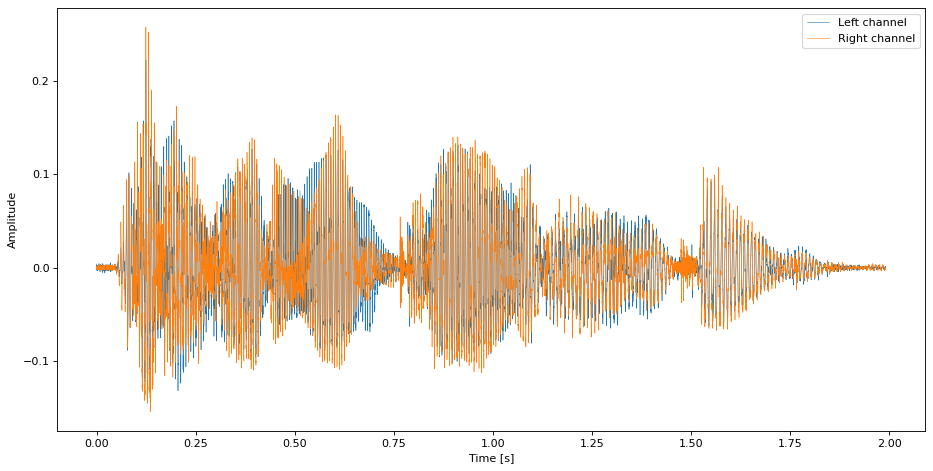

In [79]:
samplerate, stereo_data = wavfile.read('./data/lets_walk_vox_sample.wav')
length = stereo_data.shape[0] / samplerate
print(stereo_data.shape[0])
time = np.linspace(0., length, stereo_data.shape[0])

fig1 = plt.figure(figsize=(14, 7), dpi=80)
plt.plot(time, stereo_data[:, 0], label="Left channel", linewidth=0.5)
plt.plot(time, stereo_data[:, 1], label="Right channel", linewidth=0.5)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
fig1.savefig("./figures/audioSample.pdf")
plt.show()

- Select only left channel

In [72]:

data = stereo_data[:, 0]

### Signal decomposition

```python
u, s, vt = svds(Hdata, k=nk, tol=1e-10, which="LM", maxiter=100)
```

In [73]:
Hdata = hankel(data[0:2048], data[2048:-1])
nk = 100
u, s, vt = svds(Hdata, k=nk, tol=1e-10, which="LM", maxiter=100)
Fs = samplerate
NFFT = 2**14
P = np.asarray([0] * (len(data) - 1))  # 4095
P = P[:, np.newaxis]


- Build matrix of all signals
- Fourier transform with all decomposed signals

In [74]:

Pxx = np.asarray([0] * 8193)
Pxx = Pxx[:, np.newaxis]
Pfft = np.asarray([0] * NFFT)
Pfft = Pfft[:, np.newaxis]
for x in range(0, nk - 1):
    v1 = vt[x, :]
    u1 = u[:, x]
    u1 = u1[:, np.newaxis]
    v1t = v1[np.newaxis, :]
    A1 = u1 * s[x] * v1t
    P1 = np.append(A1[0, :], A1[:, -1])
    # P1=A1[0,:]
    P = np.hstack((P, P1[:, np.newaxis]))
    F, Pxx_den = signal.welch(P1, fs=Fs, window="hamm", nfft=NFFT, detrend="constant")
    ft = np.fft.fft(P1, NFFT)
    Pxx = np.hstack((Pxx, Pxx_den[:, np.newaxis]))
    Pfft = np.hstack((Pfft, ft[:, np.newaxis]))

### Ploting all decomposed signals

- Time domain of all decomposed signals

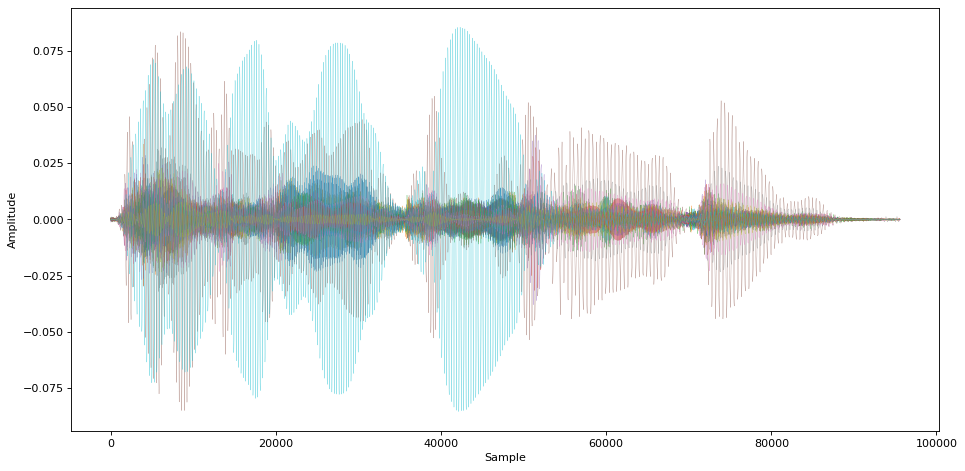

In [80]:
fig2 = plt.figure(figsize=(14, 7), dpi=80)
plt.plot(P, linewidth=0.2)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
fig2.savefig("./figures/timeDomain.pdf")
plt.show()

- Frequency domain of all decomposed signals

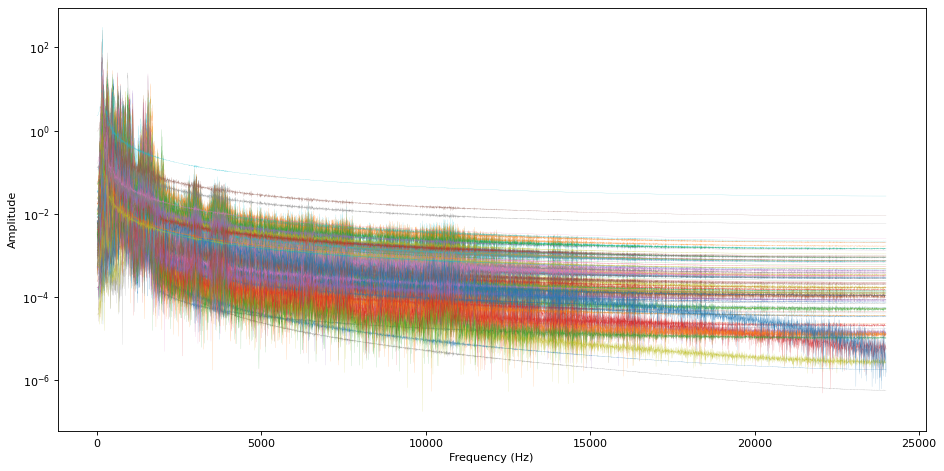

In [81]:
Nyfreq = freq[: int(NFFT / 2 - 1)]
extent = [Nyfreq[0], Nyfreq[-1], 0, nk - 1]

fig3 = plt.figure(figsize=(14, 7), dpi=80)
plt.semilogy(Nyfreq, np.abs(Pfft[: int(NFFT / 2 - 1)]), linewidth=0.1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
fig3.savefig("./figures/allFFTs.pdf")
plt.show()

- Subplot 1: Spectrogram of all decomposed signal
- Subplot 2: Sum of all decomposed FFT data

/tmp/ipykernel_29441/1271570416.py:3: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(Pfft[: int(NFFT / 2 - 1), :]).transpose()),


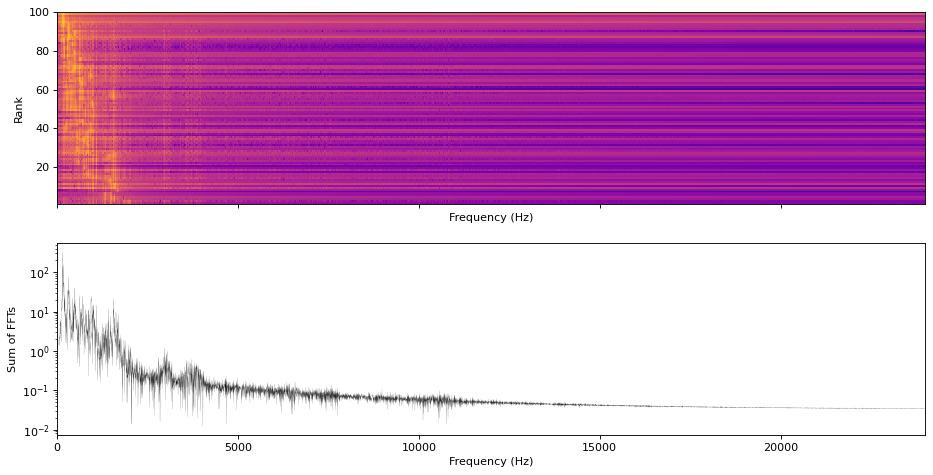

In [82]:
fig4, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 7), dpi=80, sharex=True)
ax1.imshow(
    np.log10(np.abs(Pfft[: int(NFFT / 2 - 1), :]).transpose()),
    aspect="auto",
    interpolation="none",
    extent=extent,
    cmap=plt.cm.plasma,
    origin="lower",
)
ax1.set_xlim([0, Fs / 2])
ax1.set_ylim([1, nk])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Rank")

ax2.semilogy(Nyfreq, np.abs(Pfft[: int(NFFT / 2 - 1)].sum(axis=1)), "k", linewidth=0.1)
ax2.set_xlim([0, Fs / 2])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Sum of FFTs")
fig4.savefig("./figures/spectrogram.pdf")
plt.show()